<a href="https://colab.research.google.com/github/No-Qubit-Left-Behind/NQLB/blob/master/PulseSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Propagator

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import scipy as sp
from VLDESolver import VLDESolver
from Generators import Generators
from TransferFunc import TransferFunc
from TargetFunc import TargetFunc
import time
print(tf.__version__)

2.1.0


In [4]:
x = tf.constant(
    [[0, 1], [1, 0]], dtype=tf.complex128
)
y = tf.constant(
    [[0 + 0j, 0 - 1j], [0 + 1j, 0 + 0j]], dtype=tf.complex128
)
xL = -2 * np.pi * (0 + 1j) * np.block([
    [x.numpy(), x.numpy()],
    [np.zeros((2, 2)), x.numpy()]
])
yL = -2 * np.pi * (0 + 1j) * np.block([
    [y.numpy(), y.numpy()],
    [np.zeros((2, 2)), y.numpy()]
])
VL_matrices = tf.stack([
    tf.constant(xL, dtype=tf.complex128),
    tf.constant(yL, dtype=tf.complex128)
])



ctrl_amplitudes = tf.Variable(
    tf.zeros([2, 10], dtype=tf.float64), dtype=tf.float64
)
ctrl_amplitudes.assign(
     tf.random.uniform([2, 10], -1, 1, dtype=tf.float64)
)
interval_array = 0.001 * tf.ones(100, dtype=tf.float64)


generators = Generators(VL_matrices)
transfer_func = TransferFunc(ctrl_amplitudes, interval_array)
solver = VLDESolver(generators, transfer_func)
target = TargetFunc(generators, transfer_func, solver)
optimizer = tf.keras.optimizers.Adam(0.01)


@tf.function
def optimization_step():
    with tf.GradientTape() as tape:
        current_target = target.get_target_value()
    gradients = tape.gradient(current_target, [ctrl_amplitudes])
    optimizer.apply_gradients(zip(gradients, [ctrl_amplitudes]))
    return current_target

steps = range(1000)

start = time.time()

for step in steps:
    current_target = optimization_step()
    print('step %2d: target=%2.5f' %
          (step, current_target))

end = time.time()

print(end-start)


[0.001 0.001 0.001 ... 0.001 0.001 0.001]
step  0: target=0.50758
step  1: target=0.50637
step  2: target=0.50534
step  3: target=0.50448
step  4: target=0.50376
step  5: target=0.50315
step  6: target=0.50265
step  7: target=0.50222
step  8: target=0.50186
step  9: target=0.50155
step 10: target=0.50129
step 11: target=0.50107
step 12: target=0.50089
step 13: target=0.50073
step 14: target=0.50060
step 15: target=0.50049
step 16: target=0.50040
step 17: target=0.50032
step 18: target=0.50026
step 19: target=0.50021
step 20: target=0.50017
step 21: target=0.50013
step 22: target=0.50011
step 23: target=0.50008
step 24: target=0.50006
step 25: target=0.50005
step 26: target=0.50004
step 27: target=0.50003
step 28: target=0.50002
step 29: target=0.50002
step 30: target=0.50002
step 31: target=0.50002
step 32: target=0.50002
step 33: target=0.50002
step 34: target=0.50002
step 35: target=0.50002
step 36: target=0.50002
step 37: target=0.50002
step 38: target=0.50002
step 39: target=0.5000

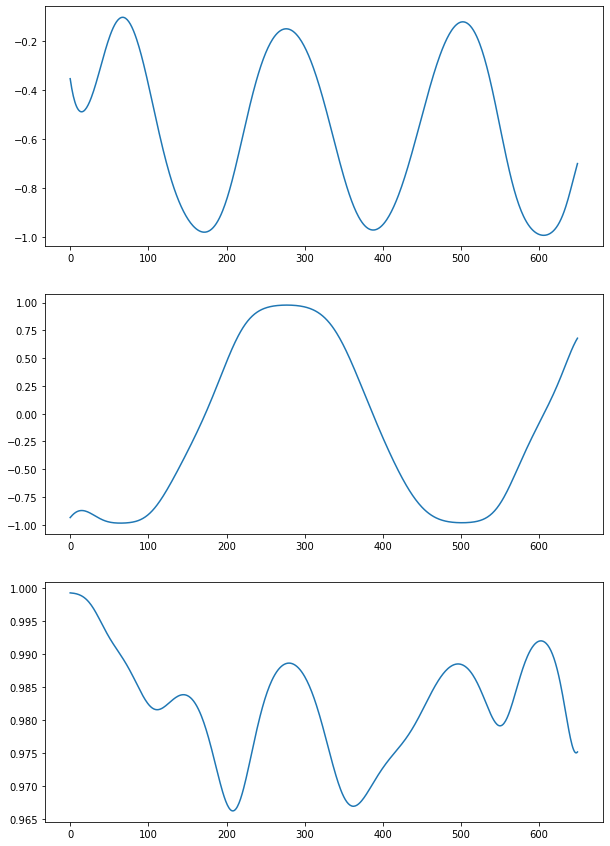

In [0]:
fig, (in_phase_fig, quadrature_fig, amplitude_fig) = plt.subplots(3, 1, figsize=(10, 15))
in_phase_fig.plot(final_pulse[:,0])
quadrature_fig.plot(final_pulse[:,1])
amplitude_fig.plot(
    np.sqrt(np.square(final_pulse[:,0]) + np.square(final_pulse[:,1]))
)